### Dataset Information

IMDB dataset contains 50K movie reviews for natural language processing i.e.  for binary sentiment classification. The dataset contains two columns - review and sentiment to perform the sentimental analysis.

### Problem Statement
Correctly classify the positive and negative sentiments for IMDB reviews.


# **1. Importing Libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost.sklearn import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import transformers
import tokenizers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_csv('/content/drive/My Drive/Data-mining/project/dataset/imdb.csv')
data.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('/content/drive/My Drive/Data-mining/project/dataset/distilbert-base-uncased')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
data.describe() #descriptive statistics

review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

In [ ]:
null_values = data.isnull().sum() #identifying missing values

In [ ]:
null_values.index[0]

'review'

In [ ]:
print('There are {} missing values for {} and {} missing values for {}.'.format(null_values[0],null_values.index[0],null_values[1],null_values.index[1]))

There are 0 missing values for review and 0 missing values for sentiment.


<ipython-input-13-5d7a3fbb60f7>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('There are {} missing values for {} and {} missing values for {}.'.format(null_values[0],null_values.index[0],null_values[1],null_values.index[1]))


In [ ]:
num_duplicates = data.duplicated().sum() #identify duplicates
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 418 duplicate reviews present in the dataset


In [ ]:
#view duplicate reviews
review = data['review']
duplicated_review = data[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head()

review sentiment
34058  "Go Fish" garnered Rose Troche rightly or wron...  negative
47467  "Go Fish" garnered Rose Troche rightly or wron...  negative
29956  "Three" is a seriously dumb shipwreck movie. M...  negative
31488  "Three" is a seriously dumb shipwreck movie. M...  negative
47527  "Witchery" might just be the most incoherent a...  negative

In [ ]:
#drop duplicate reviews
data.drop_duplicates(inplace = True)

In [ ]:
print('The dataset contains {} rows and {} columns after removing duplicates'.format(data.shape[0],data.shape[1]))

The dataset contains 49582 rows and 2 columns after removing duplicates


In [ ]:
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')
wl = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot",
           "'cause": "because", "could've": "could have", "couldn't": "could not",
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
           "might've": "might have","mightn't": "might not","mightn't've": "might not have",
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
           "she's": "she is", "should've": "should have", "shouldn't": "should not",
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is",
           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
           "here's": "here is","they'd": "they would", "they'd've": "they would have",
           "they'll": "they will", "they'll've": "they will have", "they're": "they are",
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
           "we're": "we are", "we've": "we have", "weren't": "were not",
           "what'll": "what will", "what'll've": "what will have","what're": "what are",
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would",
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
           "you're": "you are", "you've": "you have" }

In [ ]:
#function to clean data
def clean_text(text,lemmatize = True):
    soup = BeautifulSoup(text, "html.parser") #remove html tags
    text = soup.get_text()
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")]) #expanding chatwords and contracts clearing contractions
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
    text = re.sub(r'http\S+', '', text) #remove urls
    text = "".join([word.lower() for word in text if word not in string.punctuation]) #remove punctuation
    #tokens = re.split('\W+', text) #create tokens
    if lemmatize:
        text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    else:
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()])
    return text

In [ ]:
data_copy = data.copy()

In [ ]:
import nltk
nltk.download('wordnet')
data['review']=data['review'].apply(clean_text,lemmatize = True)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-20-b4726d7ad37b>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser") #remove html tags


In [ ]:
#converting target variable to numeric labels
data.sentiment = [ 1 if each == "positive" else 0 for each in data.sentiment]

In [ ]:
#after converting labels
data.head()

review  sentiment
0  one reviewer mentioned watching oz episode hoo...          1
1  wonderful little production filming technique ...          1
2  thought wonderful way spend time hot summer we...          1
3  basically family little boy jake think zombie ...          0
4  petter matteis love time money visually stunni...          1

# **3. Exploratory data analysis**

<ipython-input-25-8d7ca42fe592>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data.sentiment,palette = ['green','red'],order = [1,0])


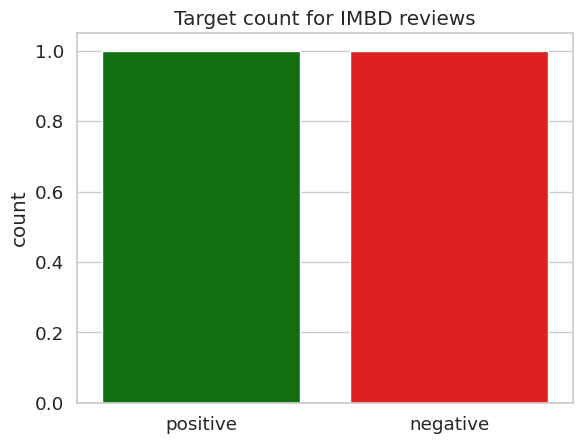

In [ ]:
### Count Plot
sns.set(style = "whitegrid" , font_scale = 1.2)
sns.countplot(data.sentiment,palette = ['green','red'],order = [1,0])
plt.xticks(ticks = np.arange(2),labels = ['positive','negative'])
plt.title('Target count for IMBD reviews')
plt.show()

In [ ]:
print('Positive reviews are', (round(data['sentiment'].value_counts()[0])),'i.e.', round(data['sentiment'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Negative reviews are', (round(data['sentiment'].value_counts()[1])),'i.e.',round(data['sentiment'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

Positive reviews are 24698 i.e. 49.81 % of the dataset
Negative reviews are 24884 i.e. 50.19 % of the dataset


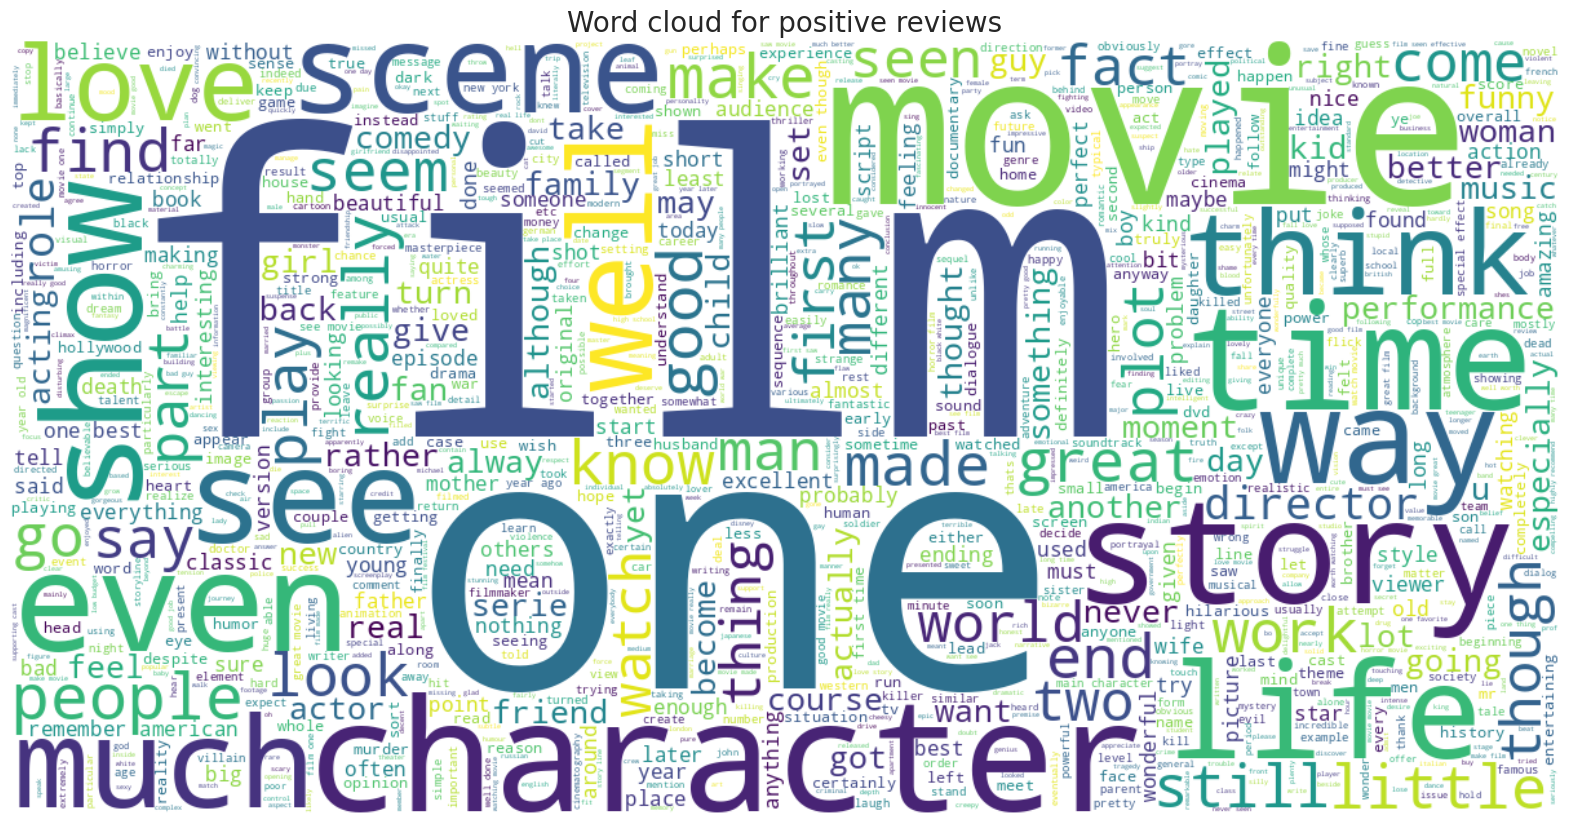

In [ ]:
#word cloud for positive reviews
positive_data = data[data.sentiment == 1]['review']
positive_data_string = ' '.join(positive_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for positive reviews',fontsize = 20)
plt.show()

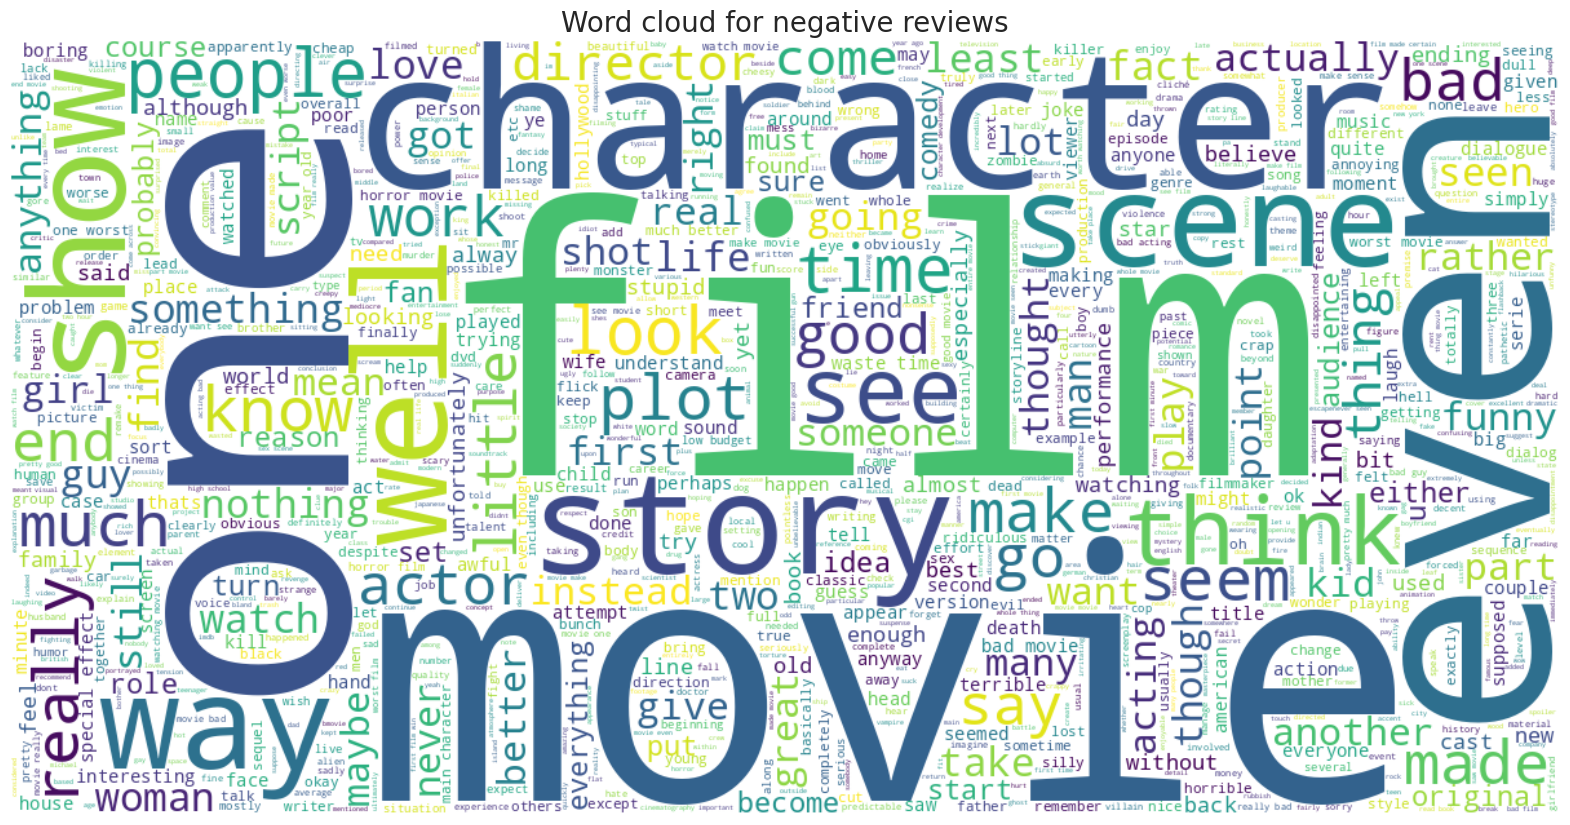

In [ ]:
#word cloud for negative reviews
negative_data = data[data.sentiment == 0]['review']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative reviews',fontsize = 20)
plt.show()

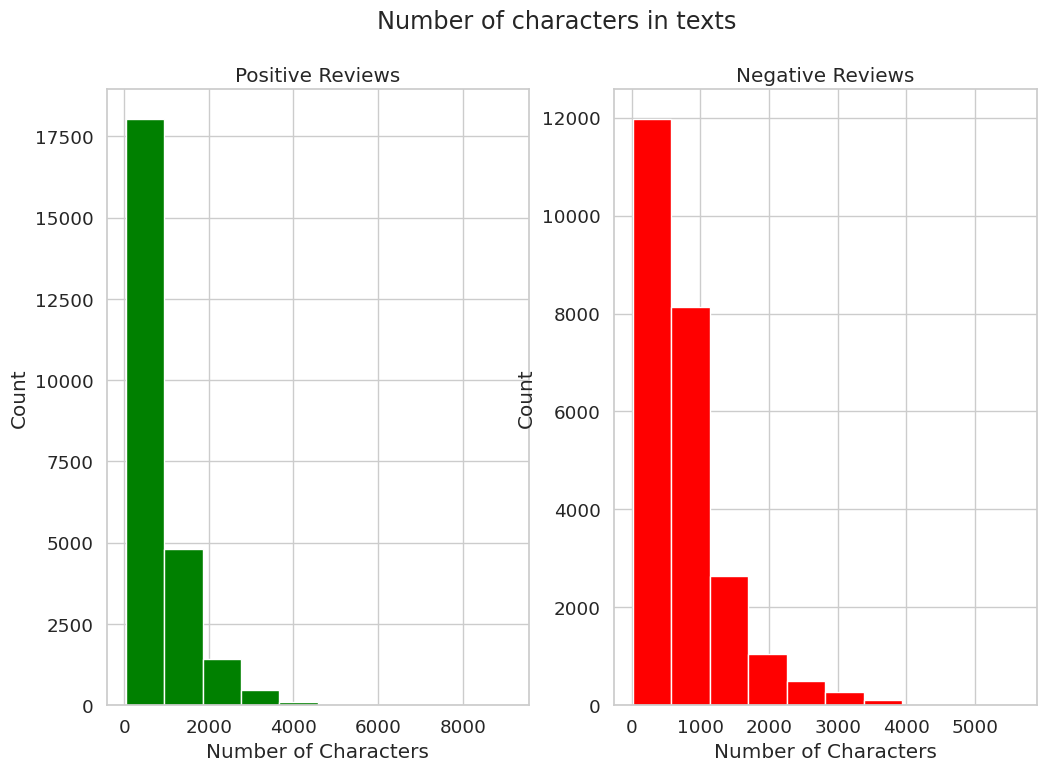

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=positive_data.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Count')
text_len=negative_data.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Count')
fig.suptitle('Number of characters in texts')
plt.show()

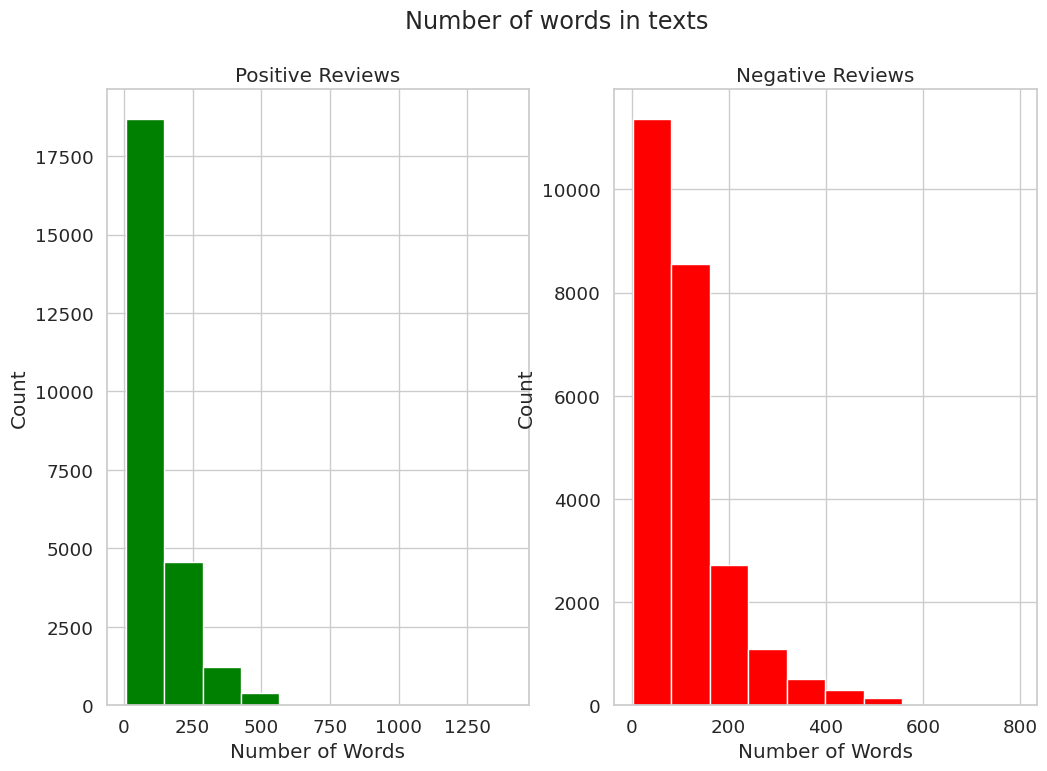

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=positive_data.str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
text_len=negative_data.str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')
fig.suptitle('Number of words in texts')
plt.show()

<ipython-input-31-644cadbc1484>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word, ax=ax1,color='green')
<ipython-input-31-644cadbc1484>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word,ax=ax2,color='red')


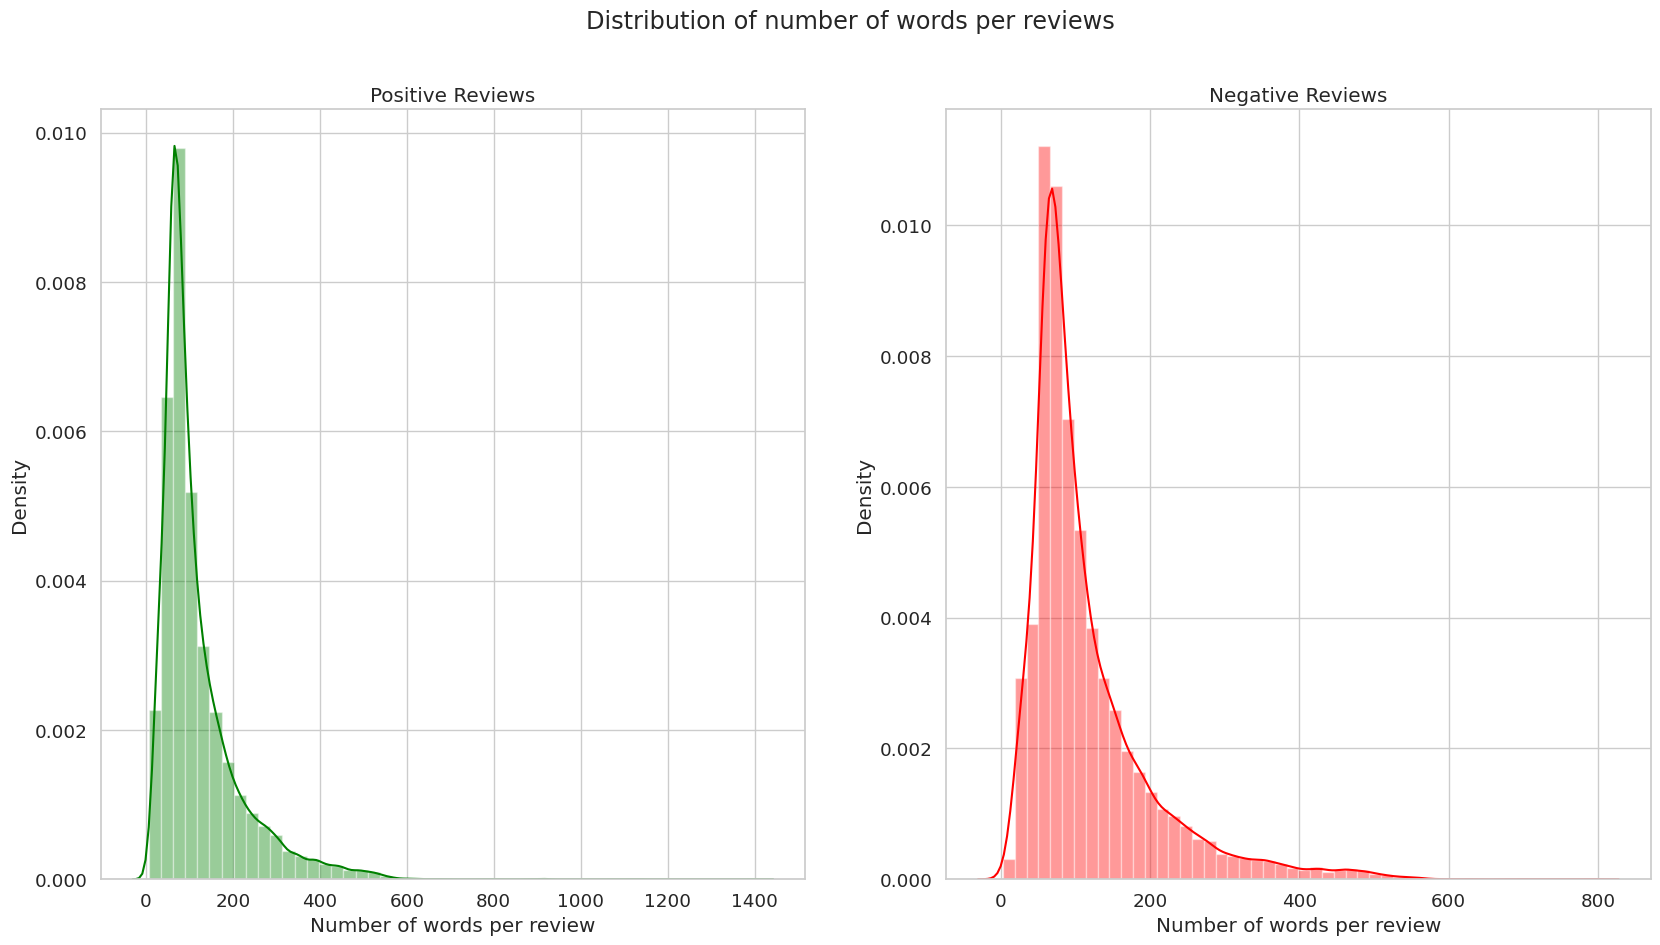

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : len(x) )
sns.distplot(word, ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of words per review')
word = negative_data.str.split().apply(lambda x :len(x) )
sns.distplot(word,ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of words per review')
fig.suptitle('Distribution of number of words per reviews')
plt.show()

<ipython-input-32-e72c0068c036>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1,color='green')
<ipython-input-32-e72c0068c036>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')


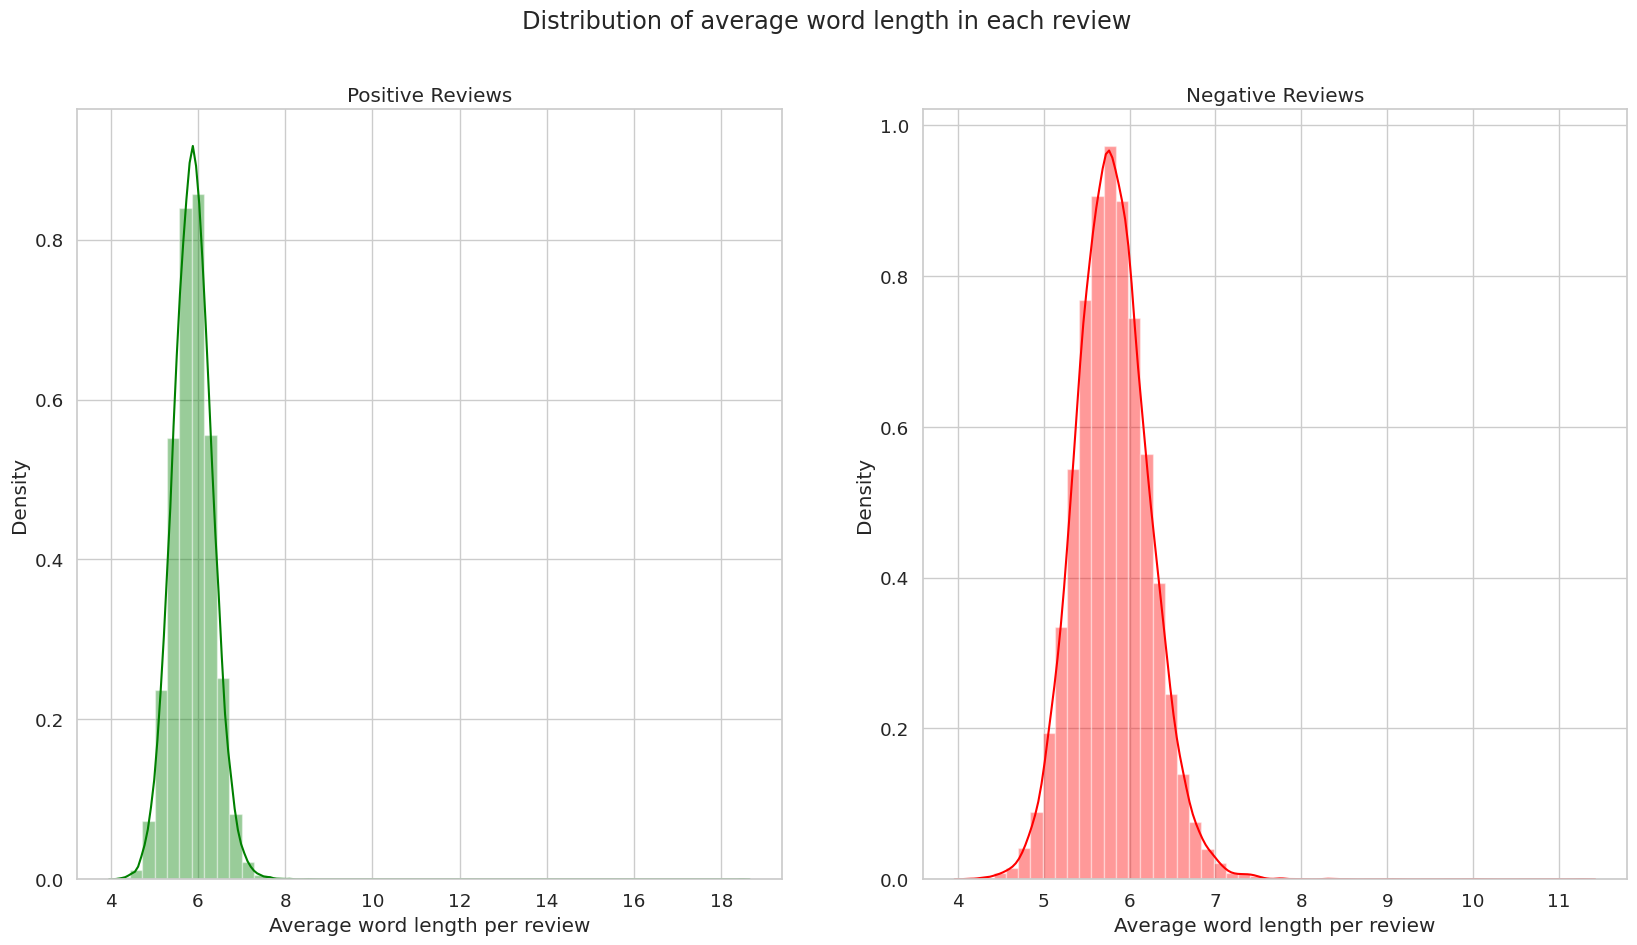

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Average word length per review')
word = negative_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Average word length per review')
fig.suptitle('Distribution of average word length in each review')
plt.show()

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.review)
corpus[:5]

['one', 'reviewer', 'mentioned', 'watching', 'oz']

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

corpus  countv
0      movie  100604
1       film   91129
2        one   53525
3       like   39746
4       time   30091
5      would   30037
6       good   28905
7  character   27798
8      story   24600
9       even   24440

In [ ]:
most_common = most_common.sort_values('countv')

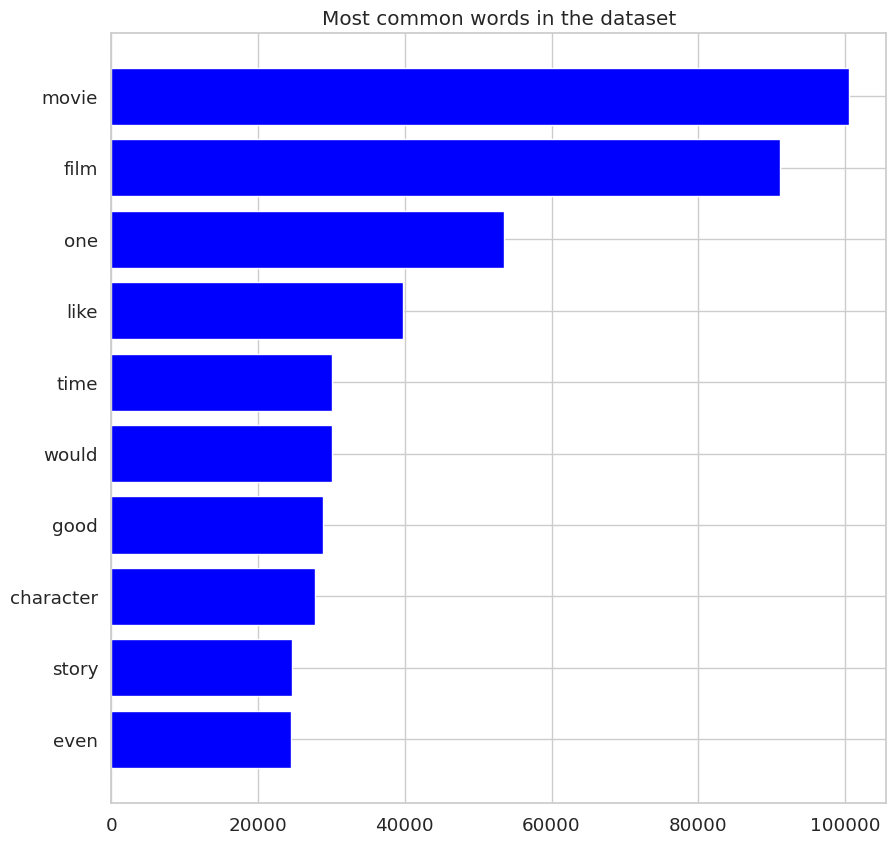

In [ ]:
plt.figure(figsize =(10,10))
plt.yticks(range(len(most_common)), list(most_common.corpus))
plt.barh(range(len(most_common)), list(most_common.countv),align='center',color = 'blue')
plt.title('Most common words in the dataset')
plt.show()


In [ ]:
def get_ngrams(review, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(review)
    bag_of_words = vec.transform(review) #sparse matrix of count_vectorizer
    sum_words = bag_of_words.sum(axis=0) #total number of words
    sum_words = np.array(sum_words)[0].tolist() #convert to list
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency
    return words_freq[:n]

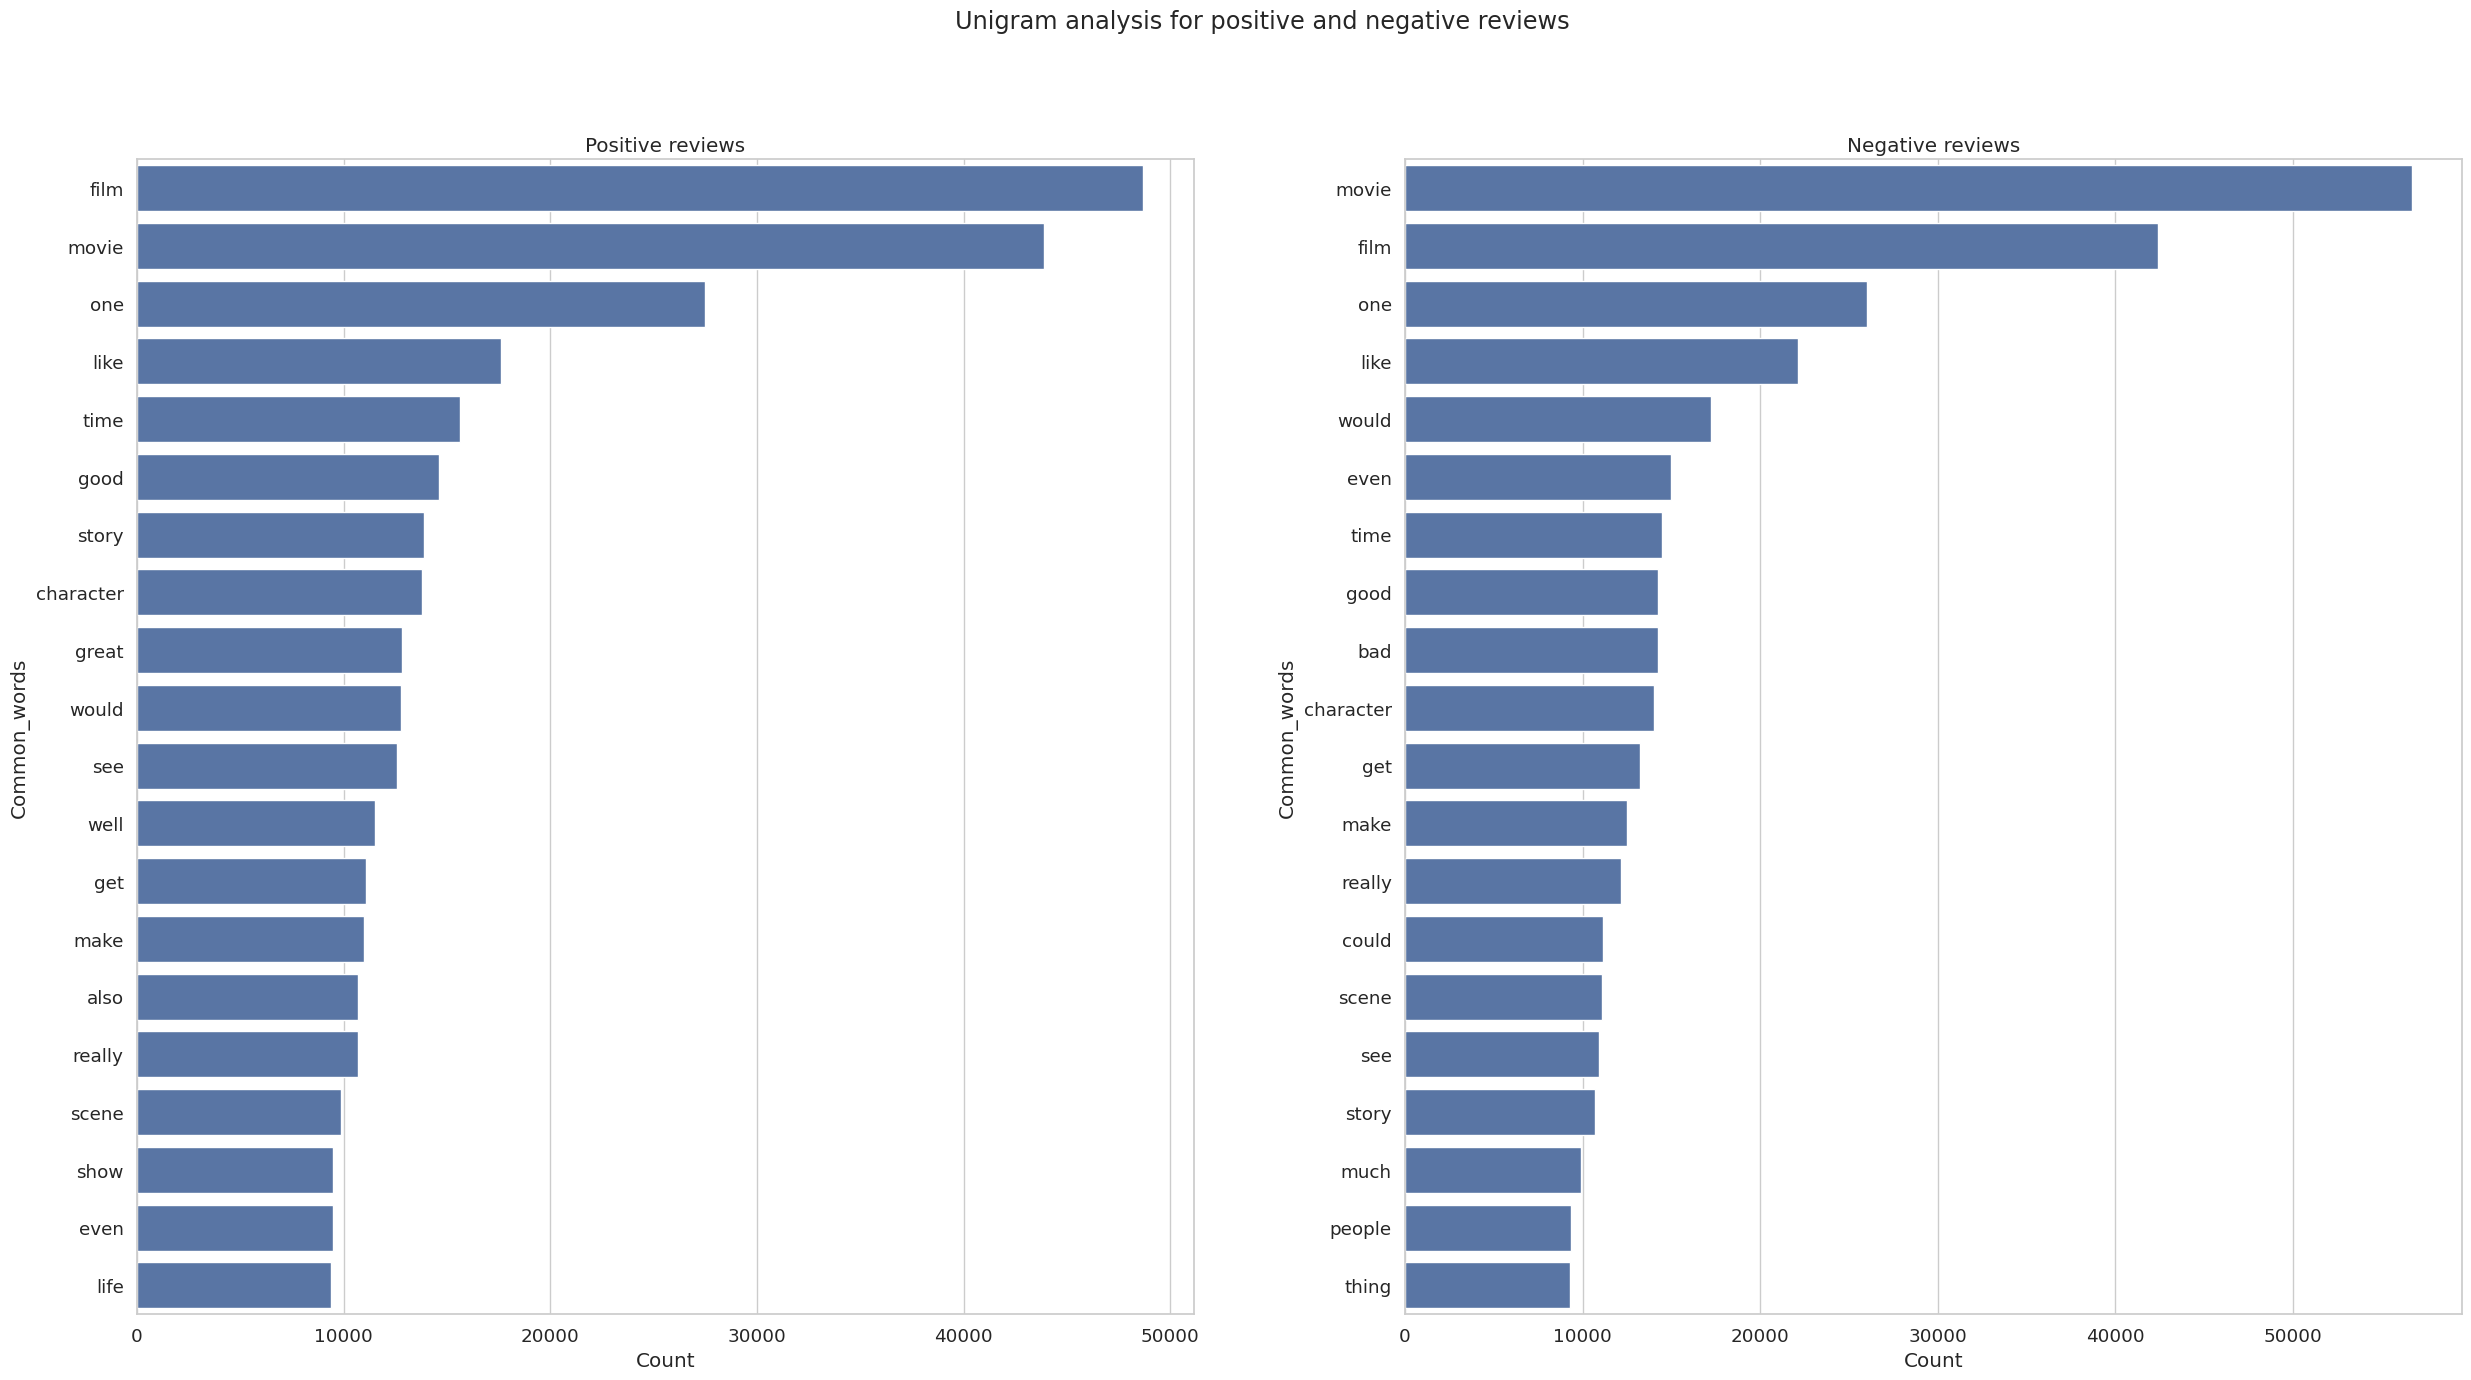

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
uni_positive = get_ngrams(positive_data,20,1)
uni_positive = dict(uni_positive)
temp = pd.DataFrame(list(uni_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
uni_negative = get_ngrams(negative_data,20,1)
uni_negative = dict(uni_negative)
temp = pd.DataFrame(list(uni_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Unigram analysis for positive and negative reviews')
plt.show()


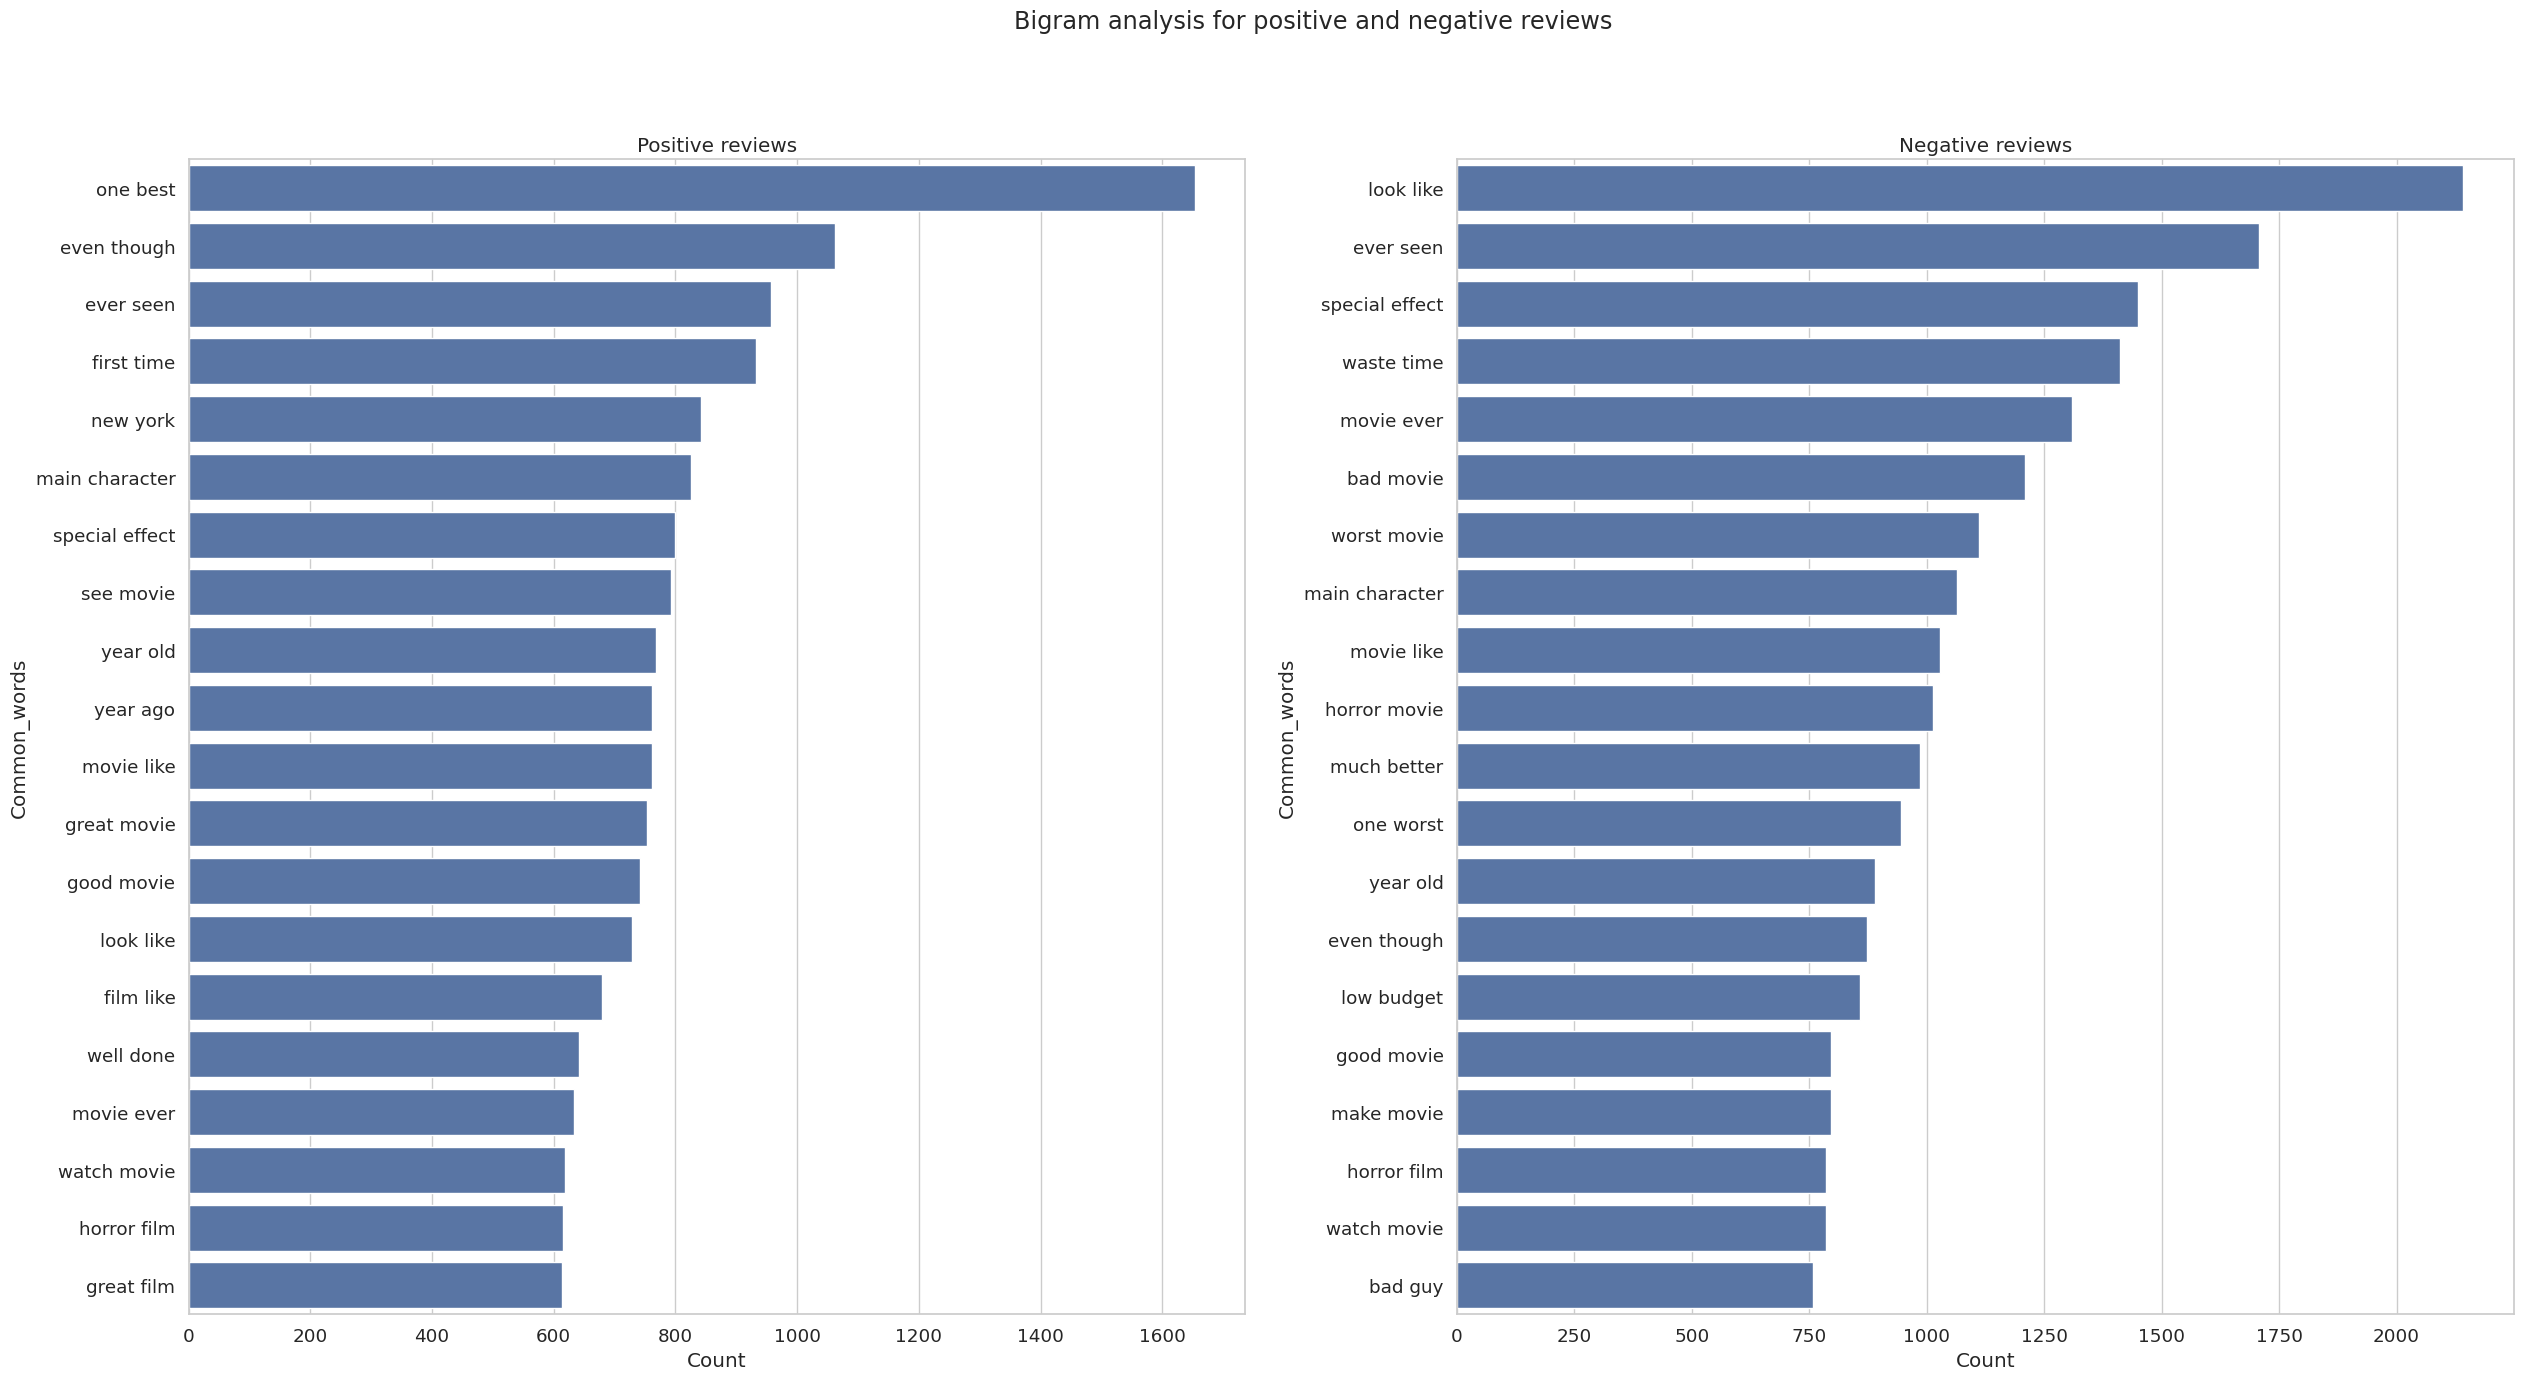

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
bi_positive = get_ngrams(positive_data,20,2)
bi_positive = dict(bi_positive)
temp = pd.DataFrame(list(bi_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
bi_negative = get_ngrams(negative_data,20,2)
bi_negative = dict(bi_negative)
temp = pd.DataFrame(list(bi_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Bigram analysis for positive and negative reviews')
plt.show()

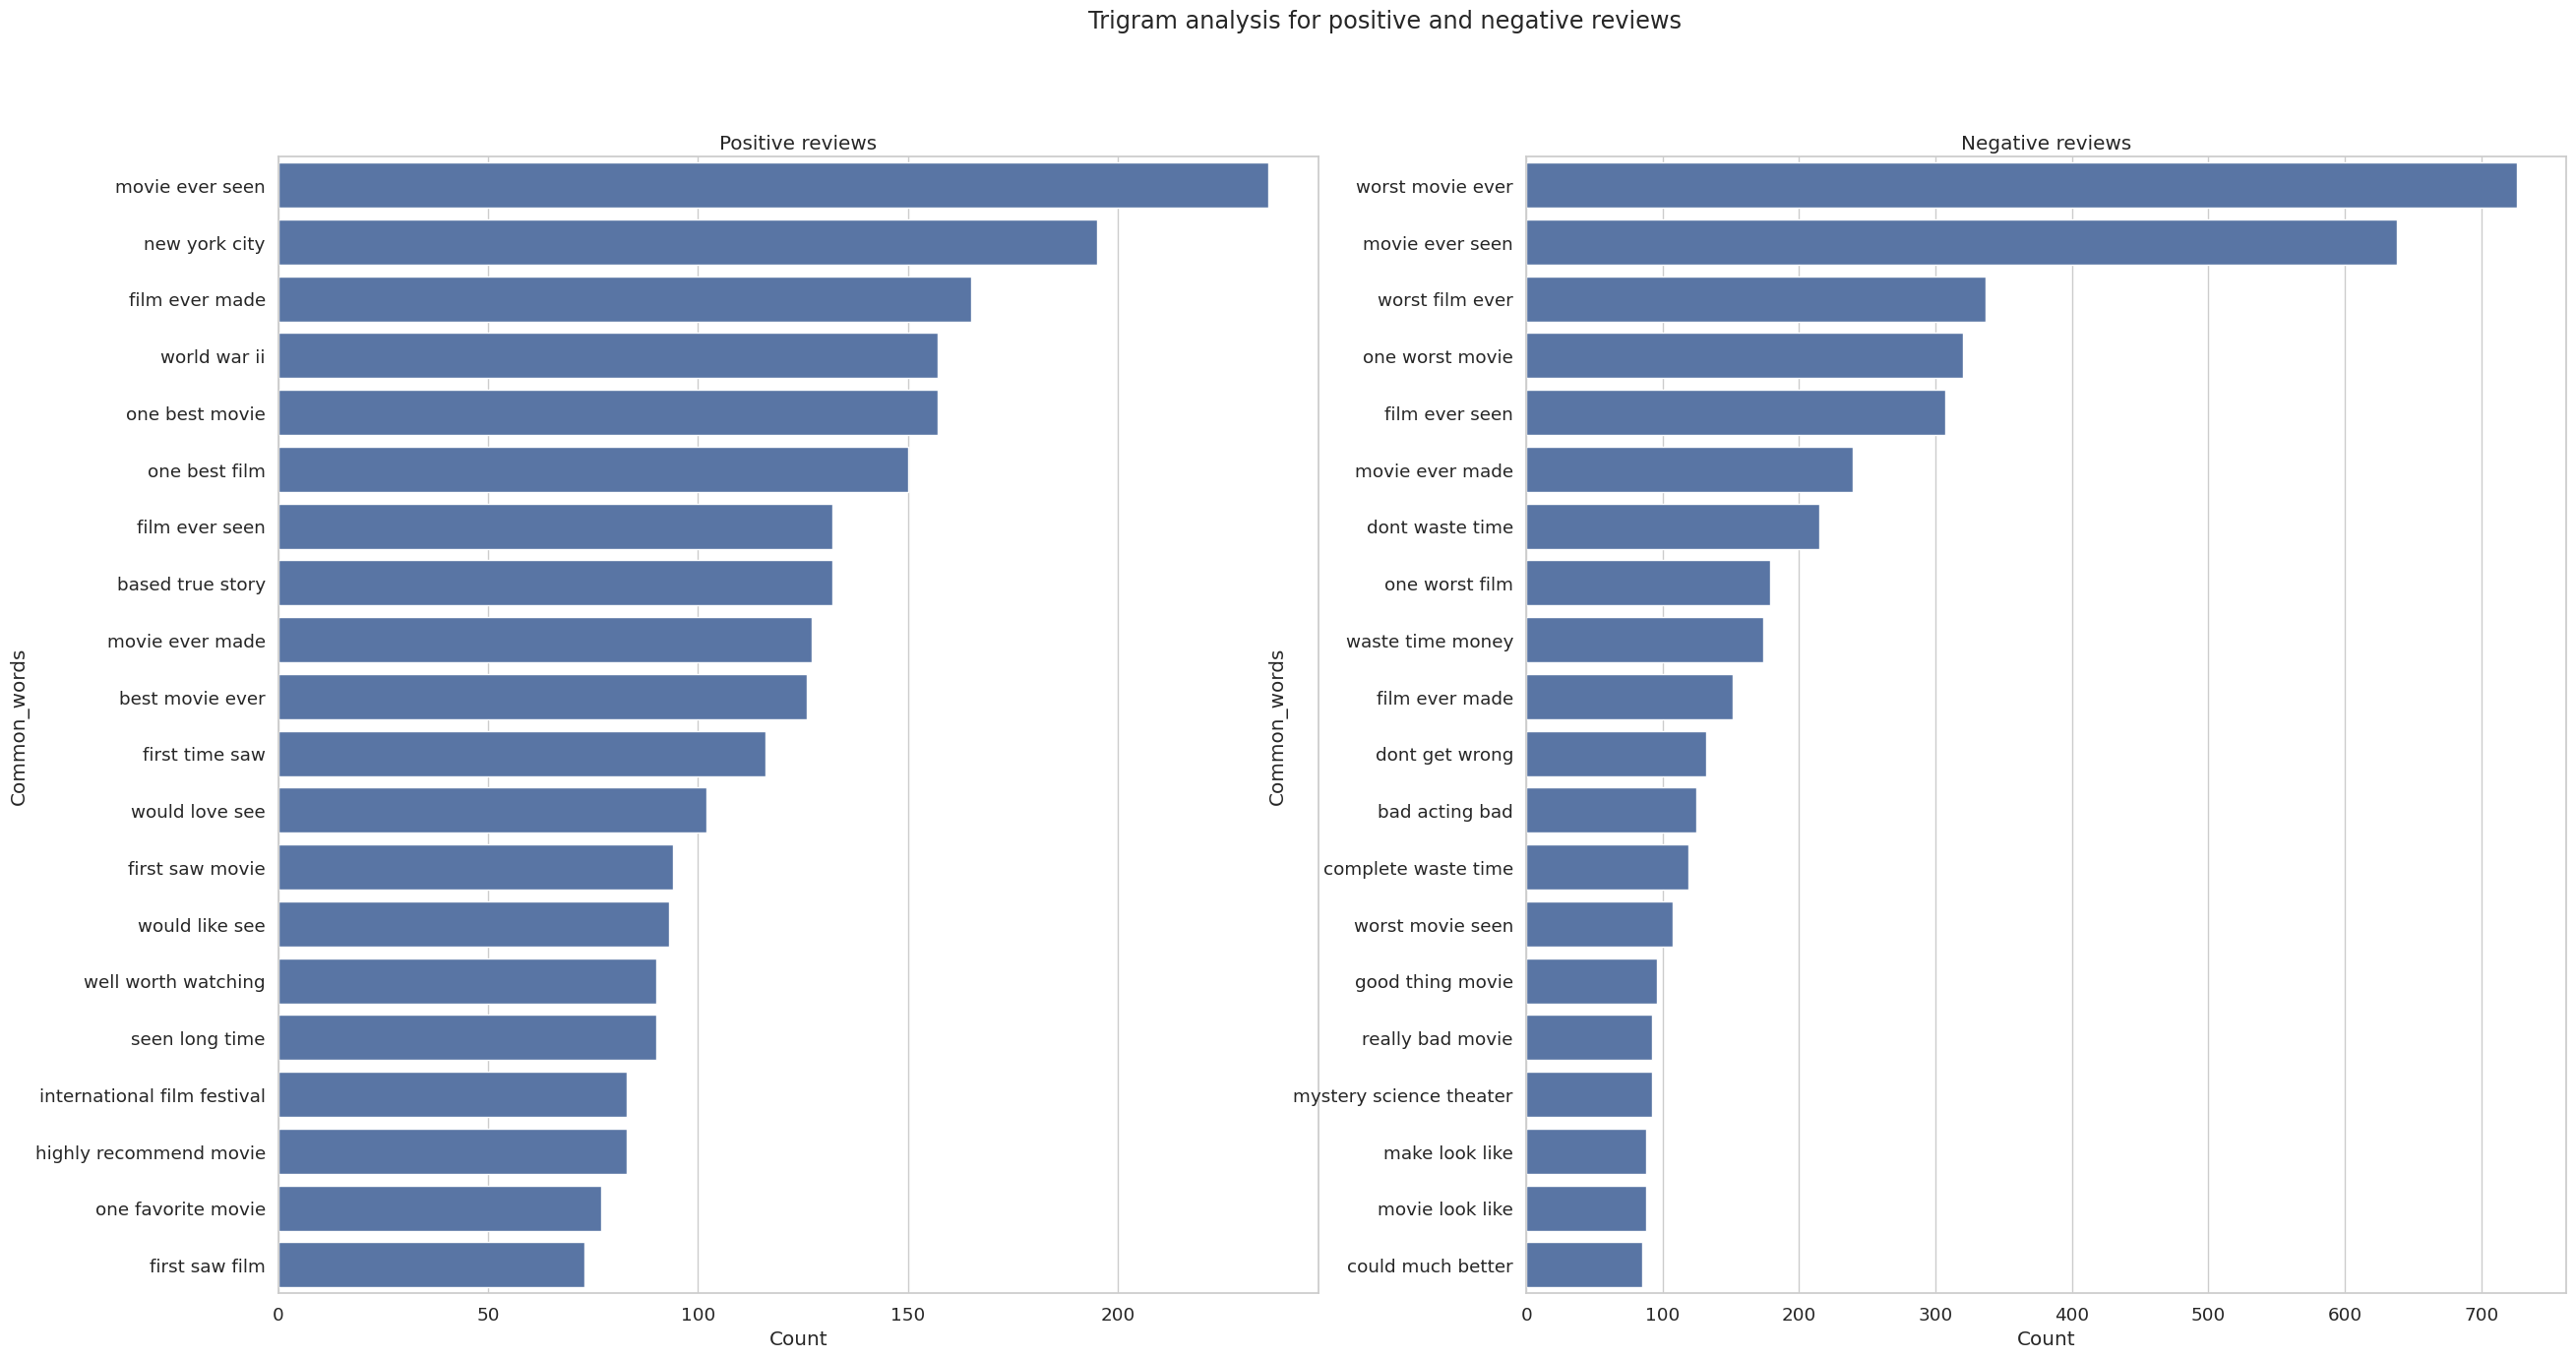

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
tri_positive = get_ngrams(positive_data,20,3)
tri_positive = dict(tri_positive)
temp = pd.DataFrame(list(tri_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
tri_negative = get_ngrams(negative_data,20,3)
tri_negative = dict(tri_negative)
temp = pd.DataFrame(list(tri_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Trigram analysis for positive and negative reviews')
plt.show()

# **4. Predictive Modelling using Machine Learning**

In [ ]:
#splitting into train and test
train, test= train_test_split(data, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

In [ ]:
#Vectorizing data

tfidf_vect = TfidfVectorizer() #tfidfVectorizer
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vect.transform(Xtest)


count_vect = CountVectorizer() # CountVectorizer
Xtrain_count = count_vect.fit_transform(Xtrain)
Xtest_count = count_vect.transform(Xtest)

### Logistic Regression

In [ ]:
!pip install --upgrade scikit-learn


In [ ]:
!pip install matplotlib


In [ ]:
!pip uninstall scikit-learn -y
!pip install scikit-learn


Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 57.3 MB/s eta 0:00:00


In [ ]:
!pip install matplotlib-venn

In [ ]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
import sklearn
print(sklearn.__version__)


1.5.2


Logistic Regression Accuracy : 89.11%


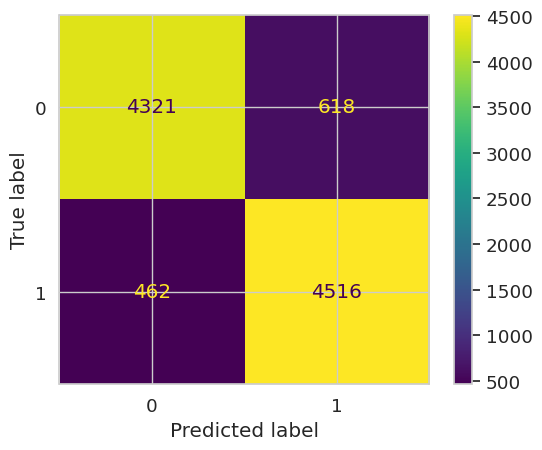

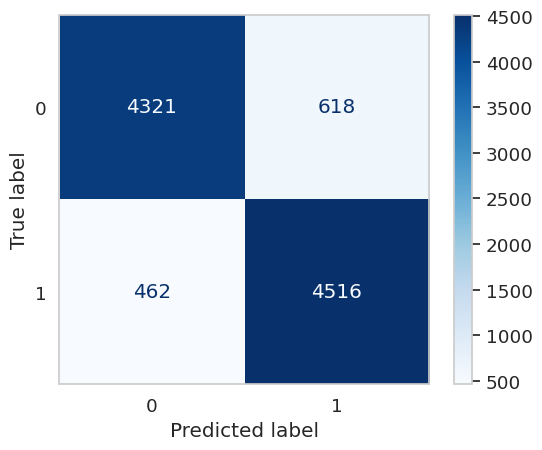

In [ ]:
lr = LogisticRegression()
lr.fit(Xtrain_tfidf,ytrain)
p1=lr.predict(Xtest_tfidf)
s1=accuracy_score(ytest,p1)
print("Logistic Regression Accuracy :", "{:.2f}%".format(100*s1))

# Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay.from_estimator(lr, Xtest_tfidf, ytest)

# Plot the confusion matrix with the desired cmap
cm_display.plot(cmap='Blues')

plt.grid(False)

Logistic Regression Accuracy : 89.11%


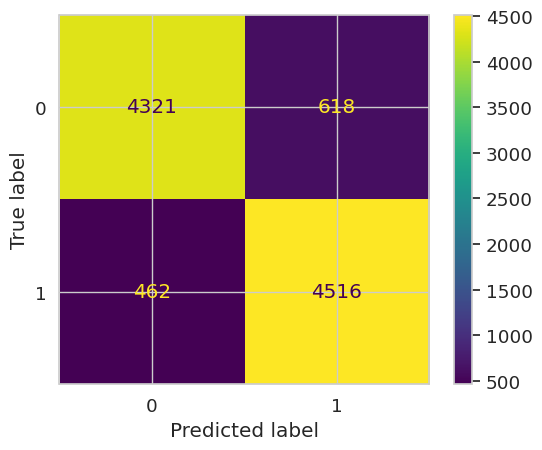

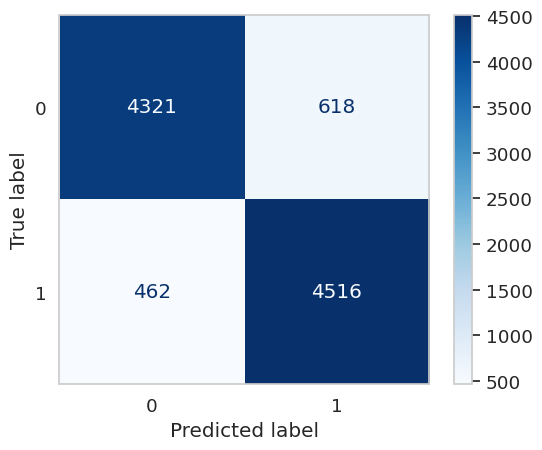

In [ ]:
from sklearn.linear_model import LogisticRegression # Import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have your Xtrain_tfidf, ytrain, Xtest_tfidf, ytest...

lr = LogisticRegression()
lr.fit(Xtrain_tfidf, ytrain)
p1 = lr.predict(Xtest_tfidf)
s1 = accuracy_score(ytest, p1)
print("Logistic Regression Accuracy :", "{:.2f}%".format(100 * s1))

# Create ConfusionMatrixDisplay object
cm = ConfusionMatrixDisplay.from_estimator(lr, Xtest_tfidf, ytest)

# Use plot() with cmap argument
cm.plot(cmap='Blues')
plt.grid(False)
plt.show()

### Multinomial Naive Bayes

Multinomial Naive Bayes Classifier Accuracy : 86.80%


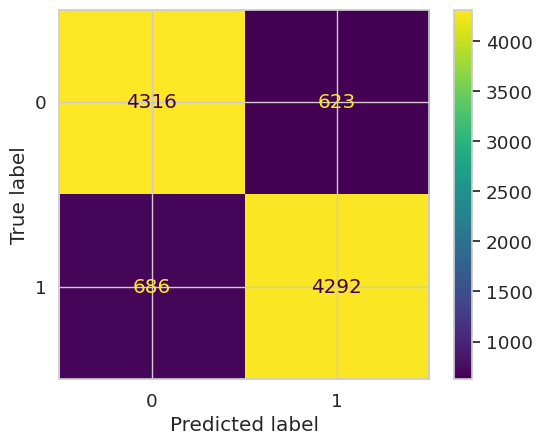

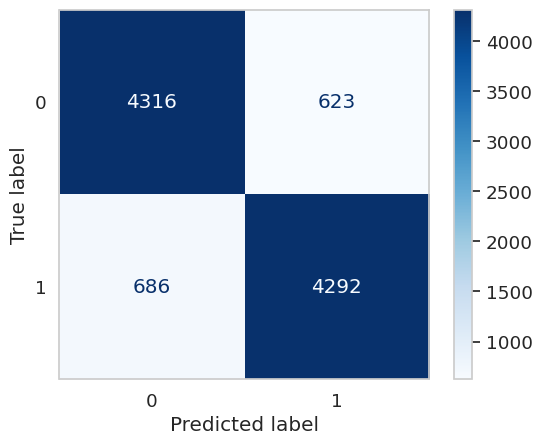

In [ ]:
mnb = MultinomialNB()
mnb.fit(Xtrain_tfidf, ytrain)
p2 = mnb.predict(Xtest_tfidf)
s2 = accuracy_score(ytest, p2)
print("Multinomial Naive Bayes Classifier Accuracy :", "{:.2f}%".format(100 * s2))

# Create ConfusionMatrixDisplay object
cm = ConfusionMatrixDisplay.from_estimator(mnb, Xtest_tfidf, ytest)

# Use plot() with cmap argument
cm.plot(cmap='Blues')
plt.grid(False)
plt.show()

### Linear SVM

Linear Support Vector Classifier Accuracy : 89.57%


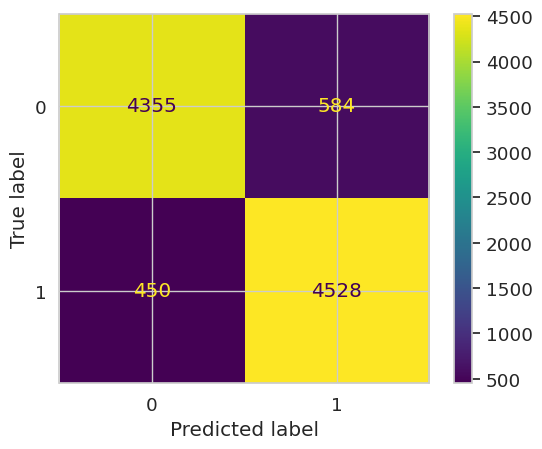

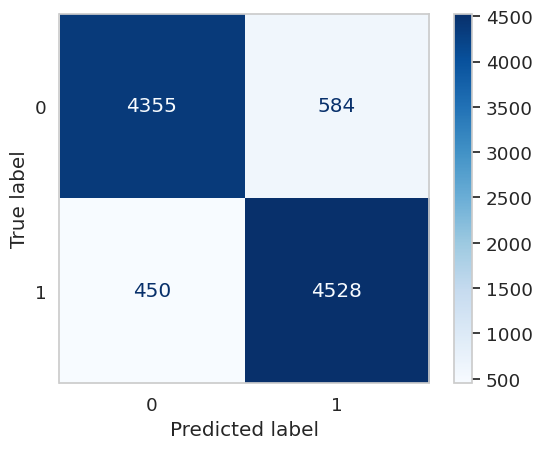

In [ ]:
linear_svc = LinearSVC(penalty='l2', loss='hinge')
linear_svc.fit(Xtrain_tfidf, ytrain)
p3 = linear_svc.predict(Xtest_tfidf)
s3 = accuracy_score(ytest, p3)
print("Linear Support Vector Classifier Accuracy :", "{:.2f}%".format(100 * s3))

# Create ConfusionMatrixDisplay object
cm = ConfusionMatrixDisplay.from_estimator(linear_svc, Xtest_tfidf, ytest)

# Use plot() with cmap argument
cm.plot(cmap='Blues')
plt.grid(False)
plt.show()

### XGboost

XGBoost Accuracy : 84.38%


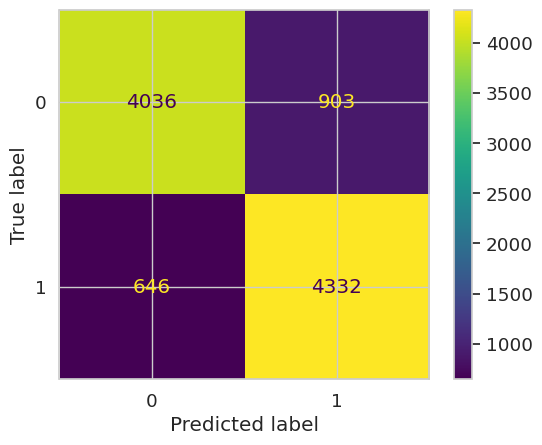

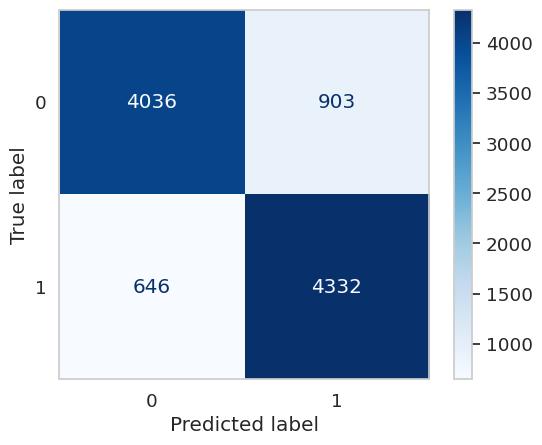

In [ ]:
from xgboost import XGBClassifier # Import XGBClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ... (Your existing code) ...

xgbo = XGBClassifier()
xgbo.fit(Xtrain_tfidf, ytrain)
p4 = xgbo.predict(Xtest_tfidf)
s4 = accuracy_score(ytest, p4)
print("XGBoost Accuracy :", "{:.2f}%".format(100 * s4))

# Create ConfusionMatrixDisplay object
cm = ConfusionMatrixDisplay.from_estimator(xgbo, Xtest_tfidf, ytest)

# Use plot() with cmap argument
cm.plot(cmap='Blues')
plt.grid(False)
plt.show()

# **5. Predictive Modelling using Deep Learning**

In [ ]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))

  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()

In [ ]:
#splitting into train and test
data_copy['review']=data_copy['review'].apply(clean_text,lemmatize = False)
#converting target variable to numerical value
data_copy.sentiment = [ 1 if each == "positive" else 0 for each in data_copy.sentiment]
train, test= train_test_split(data_copy, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

<ipython-input-20-b4726d7ad37b>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser") #remove html tags


### LSTM

In [ ]:
#set up the tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index
#print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)


Vocabulary of the dataset is :  136569


In [ ]:
##create sequences of reviews
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test =  tokenizer.texts_to_sequences(Xtest)

In [ ]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 1406


In [ ]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 293


In [ ]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))


The above calculated number coveres approximately 94.51 % of data


So we can use this number for our maxlen parameter.

In [ ]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [ ]:
#Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,ytrain,
                                             test_size=0.2,random_state=10)

In [ ]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#     #early_stop = EarlyStopping(monitor='val_accuracy',
#                                mode='min',
#                                patience = 2 )
#     #checkpoints= ModelCheckpoint(filepath='./',
#                             monitor="val_accuracy",
#                             verbose=0,
#                             save_best_only=True
#                            )
  #  callbacks = [checkpoints,early_stop]
    r = model.fit(Xtrain,ytrain,
                  validation_data = (Xval,yval),
                  epochs = epochs,
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])

    return r,model,n_epochs


In [ ]:
D = 64 #embedding dims
epochs = 5
r,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

----Building the model----


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 293)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 293, 64)             │       8,740,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 293, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 293, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 289, 32)             │          10,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 289, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 144, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 144, 256)            │         164,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,998,113 (34.33 MB)

 Trainable params: 8,997,985 (34.32 MB)

 Non-trainable params: 128 (512.00 B)

----Training the network----
Epoch 1/5
992/992 - 38s - 38ms/step - accuracy: 0.7412 - loss: 0.4930 - val_accuracy: 0.8860 - val_loss: 0.2850
Epoch 2/5
992/992 - 33s - 33ms/step - accuracy: 0.8908 - loss: 0.2746 - val_accuracy: 0.8821 - val_loss: 0.2809
Epoch 3/5
992/992 - 41s - 41ms/step - accuracy: 0.9157 - loss: 0.2156 - val_accuracy: 0.8864 - val_loss: 0.2781
Epoch 4/5
992/992 - 41s - 42ms/step - accuracy: 0.9382 - loss: 0.1656 - val_accuracy: 0.8893 - val_loss: 0.3102
Epoch 5/5
992/992 - 41s - 41ms/step - accuracy: 0.9517 - loss: 0.1318 - val_accuracy: 0.8869 - val_loss: 0.3233
992/992 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9789 - loss: 0.0690
Train score: [0.06657106429338455, 0.9800201654434204]
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8923 - loss: 0.3009
Validation score: [0.32328706979751587, 0.8869280219078064]


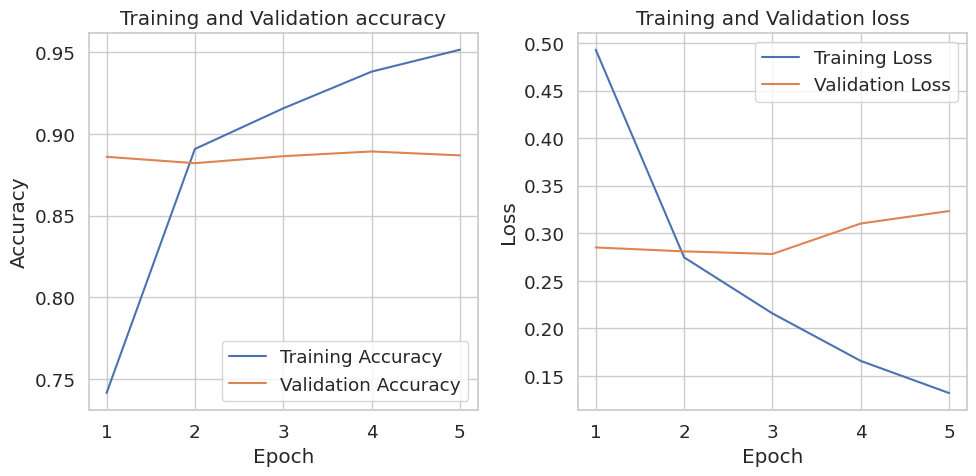

In [ ]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [ ]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,ytest)
print(dict(zip(model.metrics_names, result)))

Evaluate Model Performance on Test set
310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8767 - loss: 0.3496
{'loss': 0.3559643030166626, 'compile_metrics': 0.8748613595962524}


310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


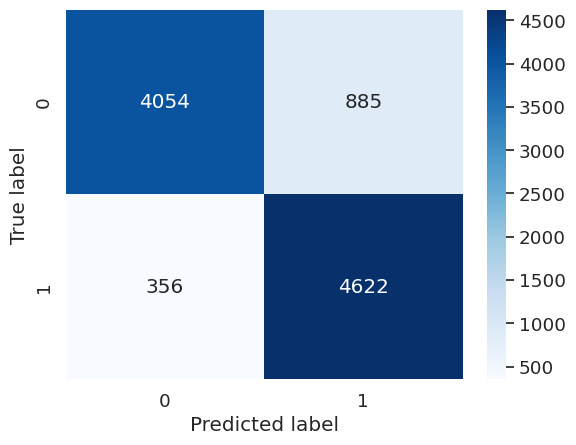

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### BERT


In [ ]:
train, test= train_test_split(data_copy, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']
#splitting the train set into train and validation
Xtrain,Xval,ytrain,yval=train_test_split(Xtrain,ytrain,
                                             test_size=0.2,random_state=10)

In [ ]:
#Perform tokenization
# automatically download the vocab used during pretraining or fine-tuning a given model,use from_pretrained() method
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#pass our texts to the tokenizer.
Xtrain_enc = tokenizer(Xtrain.tolist(), max_length=max_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='np') #return numpy object
# Get the values for 'input_ids' and 'attention_mask'
Xtrain_enc = {
    'input_ids': Xtrain_enc['input_ids'],
    'attention_mask': Xtrain_enc['attention_mask']
}

Xval_enc = tokenizer(Xval.tolist(), max_length=max_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='np') #return numpy object
# Get the values for 'input_ids' and 'attention_mask'
Xval_enc = {
    'input_ids': Xval_enc['input_ids'],
    'attention_mask': Xval_enc['attention_mask']
}

Xtest_enc = tokenizer(Xtest.tolist(), max_length=max_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='np') #return numpy object
# Get the values for 'input_ids' and 'attention_mask'
Xtest_enc = {
    'input_ids': Xtest_enc['input_ids'],
    'attention_mask': Xtest_enc['attention_mask']
}

In [ ]:
#pass our texts to the tokenizer.
Xtrain_enc = tokenizer(Xtrain.tolist(), max_length=max_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='np') #return numpy object
# Get the values for 'input_ids' and 'attention_mask'
# Ensure that the shapes are correct after tokenization
Xtrain_enc = {
    'input_ids': Xtrain_enc['input_ids'][:, :max_len], # Slice to max_len
    'attention_mask': Xtrain_enc['attention_mask'][:, :max_len] # Slice to max_len
}

Xval_enc = tokenizer(Xval.tolist(), max_length=max_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='np') #return numpy object
# Get the values for 'input_ids' and 'attention_mask'
# Ensure that the shapes are correct after tokenization
Xval_enc = {
    'input_ids': Xval_enc['input_ids'][:, :max_len], # Slice to max_len
    'attention_mask': Xval_enc['attention_mask'][:, :max_len] # Slice to max_len
}

Xtest_enc = tokenizer(Xtest.tolist(), max_length=max_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='np') #return numpy object
# Get the values for 'input_ids' and 'attention_mask'
# Ensure that the shapes are correct after tokenization
Xtest_enc = {
    'input_ids': Xtest_enc['input_ids'][:, :max_len], # Slice to max_len
    'attention_mask': Xtest_enc['attention_mask'][:, :max_len] # Slice to max_len
}

In [ ]:
#preparing our datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtrain_enc),
    ytrain
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xval_enc),
    yval
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtest_enc),
    ytest
))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import transformers

def bert_model(train_dataset, val_dataset, transformer, max_len, epochs, Xtrain_enc, Xval_enc, ytrain, yval):
    print("----Building the model----")
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

    class TransformerLayer(tf.keras.layers.Layer):
        def __init__(self, transformer):
            super(TransformerLayer, self).__init__()
            self.transformer = transformer

        def call(self, inputs):
            input_ids, attention_mask = inputs
            return self.transformer(tf.cast(input_ids, tf.int32), attention_mask=tf.cast(attention_mask, tf.int32))[0]

    sequence_output = TransformerLayer(transformer)([input_ids, attention_mask])

    cls_token = sequence_output[:, 0, :]
    x = Dense(512, activation='relu')(cls_token)
    x = Dropout(0.1)(x)
    y = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input_ids, attention_mask], outputs=y)
    model.summary()
    model.compile(Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

    # Disable XLA compilation
    tf.config.optimizer.set_jit(False)

    # Create datasets with correct types using tf.data.Dataset.from_tensor_slices
    train_dataset = tf.data.Dataset.from_tensor_slices((
        {k: tf.cast(v, tf.int32) for k, v in dict(Xtrain_enc).items()},  # Cast to int32 here
        tf.cast(ytrain.map({'negative': 0, 'positive': 1}), tf.int32) # Convert labels to numerical
    )).batch(32)

    val_dataset = tf.data.Dataset.from_tensor_slices((
        {k: tf.cast(v, tf.int32) for k, v in dict(Xval_enc).items()},  # Cast to int32 here
        tf.cast(yval.map({'negative': 0, 'positive': 1}), tf.int32) # Convert labels to numerical
    )).batch(32)

    # Remove run_eagerly=True from model.fit()
    r = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

    print("Train score:", model.evaluate(train_dataset))
    print("Validation score:", model.evaluate(val_dataset))
    n_epochs = len(r.history['loss'])

    return r, model, n_epochs


In [ ]:
transformer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
epochs = 2
max_len = 293  # Replace with your sequence length
r, model, n_epochs = bert_model(train_dataset, val_dataset, transformer, max_len, epochs, Xtrain_enc, Xval_enc, ytrain, yval) # Pass 'Xtrain_enc', 'Xval_enc', 'ytrain', and 'yval' as arguments

----Building the model----


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 293)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 293)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_layer_4       │ (None, 293, 768)       │              0 │ input_ids[0][0],       │
│ (TransformerLayer)        │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 768)            │              0 │ transformer_layer_4[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 512)            │        393,728 │ get_item_4[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 512)            │          2,048 │ dense_9[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 512)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1)              │            513 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 396,289 (1.51 MB)

 Trainable params: 395,265 (1.51 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/2
992/992 ━━━━━━━━━━━━━━━━━━━━ 393s 382ms/step - accuracy: 0.0000e+00 - loss: -169958944.0000 - val_accuracy: 0.0000e+00 - val_loss: -243603280.0000
Epoch 2/2
992/992 ━━━━━━━━━━━━━━━━━━━━ 364s 367ms/step - accuracy: 0.0000e+00 - loss: -867459200.0000 - val_accuracy: 0.0000e+00 - val_loss: -725822592.0000
992/992 ━━━━━━━━━━━━━━━━━━━━ 293s 295ms/step - accuracy: 0.0000e+00 - loss: -792044288.0000
Train score: [-868866368.0, 0.0]
248/248 ━━━━━━━━━━━━━━━━━━━━ 73s 295ms/step - accuracy: 0.0000e+00 - loss: -723112576.0000
Validation score: [-725822592.0, 0.0]


In [ ]:
import matplotlib.pyplot as plt

def plotLearningCurve(r, n_epochs):
    # Plot training & validation accuracy values
    plt.plot(r.history['accuracy'])
    plt.plot(r.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(r.history['loss'])
    plt.plot(r.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

# ... (rest of your code) ...

# Call the function after training
plotLearningCurve(r, n_epochs)

In [ ]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(test_dataset.batch(32))
print(dict(zip(model.metrics_names, result)))

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(test_dataset.batch(32))
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

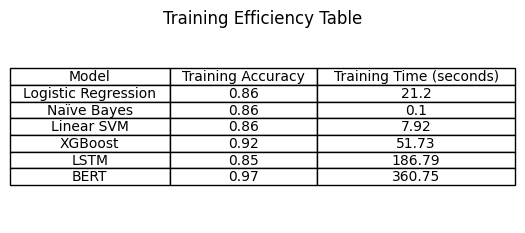

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the data
data = {
    "Model": ["Logistic Regression", "Naïve Bayes", "Linear SVM", "XGBoost", "LSTM", "BERT"],
    "Training Accuracy": [0.86, 0.86, 0.86, 0.92, 0.85, 0.97],
     "Training Time (seconds)": [21.20, 0.10, 7.92, 51.73, 186.79, 360.75],

}


# Create a DataFrame
df = pd.DataFrame(data)

# Create a Matplotlib figure
fig, ax = plt.subplots(figsize=(6, 2.5))  # Set a smaller figure size
ax.axis('tight')
ax.axis('off')

# Create a table in the figure
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

# Adjust table properties for better appearance
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df.columns))))  # Adjust column width

# Add a tighter title
plt.title("Training Efficiency Table", fontsize=12, pad=5)  # Reduce title gap

# Display the figure
plt.show()


###